## Exploratory Data Analysis

Use this notebook to get familiar with the datasets we have. There is 10 questions we need to answer during the EDA.


We shouldn't limit our EDA to these 10 questions. Let's be creative :).

Below, we will select the entire table for a certain number of random entries and work with that, since the table "flights" has like 16 million entries...

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [193]:
flight_delay = pd.read_csv("flight_information.csv")

In [195]:
# Some feature engineering/data prep
flight_delay['arr_delay'] = flight_delay["arr_delay"].fillna(0)
flight_delay["dep_delay"] = flight_delay["dep_delay"].fillna(0)

#### **Task 1**: Test the hypothesis that the delay is from Normal distribution. and that **mean** of the delay is 0. Be careful about the outliers.

The mean flight delay is 4.5 minutes.
If we only consider delayed flights, the mean flight delay is 37.4 minutes.


<AxesSubplot:xlabel='arr_delay'>

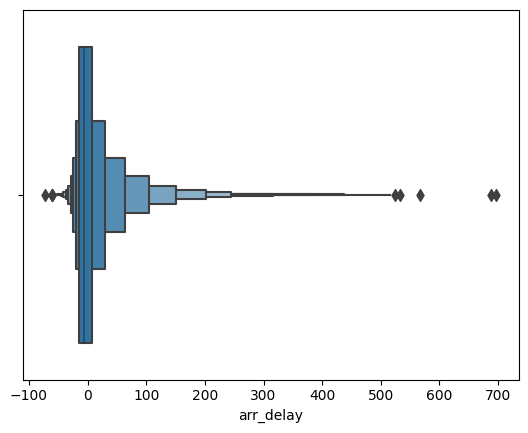

In [157]:
import seaborn as sns

delay = flight_delay['arr_delay'].mean()
actual_delay = flight_delay[flight_delay['arr_delay']>0]['arr_delay'].mean()

print(f'The mean flight delay is {delay:.1f} minutes.')
print(f'If we only consider delayed flights, the mean flight delay is {actual_delay:.1f} minutes.')
        
sns.boxenplot(data = flight_delay, x = "arr_delay")


In [92]:
flight_delay['log delay'] = np.log10(flight_delay['arr_delay'])

/home/marcjb/anaconda3/envs/lhl_env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/marcjb/anaconda3/envs/lhl_env/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='log delay', ylabel='Count'>

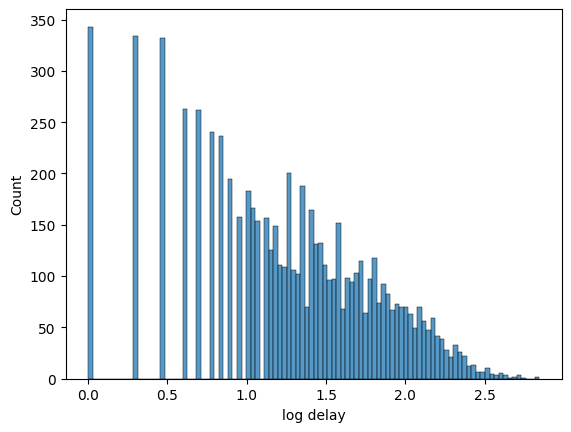

In [94]:
sns.histplot(data = flight_delay, x = "log delay", bins = 100)
#Actual log scale
# sns.histplot(data = flight_delay, x = "arr_delay", bins = 100, log_scale= True)

#### **Task 2**: Is average/median monthly delay different during the year? If yes, which are months with the biggest delays and what could be the reason?

In [175]:
df = flight_delay[['fl_date', 'arr_delay']]

In [176]:
df['month']= pd.DatetimeIndex(df['fl_date']).month

#Looking only at delays
delay_df = df[df['arr_delay']>5].reset_index(drop=True)
# df
delay_df.groupby('month').mean()

/tmp/ipykernel_46478/4187747994.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month']= pd.DatetimeIndex(df['fl_date']).month


,arr_delay
month,
1,43.536058
2,43.995370
3,46.245146
4,44.392344
5,50.243243
6,55.893309
7,52.119374
8,54.094697
9,41.329480


Seems like Summer months have largest delays. Are those also the months with the highest number of flights? Let's check...

In [9]:
df.groupby('month')['fl_date'].count()

month
1     1530
2     1416
3     1741
4     1626
5     1783
6     1714
7     1809
8     1748
9     1600
10    1707
11    1658
12    1668
Name: fl_date, dtype: int64

Looks like it...hmmm

In [177]:
flight_delay_time = 20
delay = df[df['arr_delay']>flight_delay_time].groupby('month').count().sort_values(by=['arr_delay'], ascending=False)
total = df.groupby('month').count().sort_values(by=['arr_delay'], ascending=False)

mon_df = pd.merge(delay, total, how = "inner", on='month')
mon_df = mon_df.rename(columns={'arr_delay_x': "total_delays", 'arr_delay_y': "total_flights"})
mon_df = mon_df.drop(columns=['fl_date_x', 'fl_date_y'])
mon_df['percent_delayed'] = mon_df['total_delays']/mon_df['total_flights']

mon_df.sort_values(by=['percent_delayed'], ascending=False)

,total_delays,total_flights,percent_delayed
month,,,
6,349,1714,0.203617
8,338,1748,0.193364
12,302,1668,0.181055
7,320,1809,0.176893
2,248,1416,0.175141
5,300,1783,0.168256
11,242,1658,0.145959
1,222,1530,0.145098
4,230,1626,0.141451


#### **Task 3**: Does the weather affect the delay? 
Use the API to pull the weather information for flights. There is no need to get weather for ALL flights. We can choose the right representative sample. Let's focus on four weather types:
- sunny
- cloudy
- rainy
- snow.
Test the hypothesis that these 4 delays are from the same distribution. If they are not, which ones are significantly different?

#### **Task 4**: How taxi times changing during the day? Does higher traffic lead to bigger taxi times?

In [178]:
df = flight_delay[['crs_dep_time', 'arr_delay', 'taxi_out']]

In [179]:
df['hr_dep'] = df['crs_dep_time'] // 100 #Extract the hour of departure
df_dep = df.groupby("hr_dep")['taxi_out'].mean()

/tmp/ipykernel_46478/2251038840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hr_dep'] = df['crs_dep_time'] // 100 #Extract the hour of departure


<AxesSubplot:xlabel='crs_dep_time', ylabel='Count'>

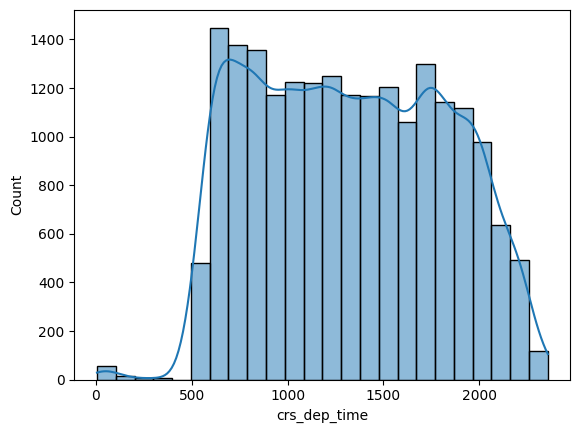

In [180]:
sns.histplot(data = df, x = "crs_dep_time",bins = 24, label = "Departure time", kde=True)

<AxesSubplot:xlabel='taxi_out', ylabel='Count'>

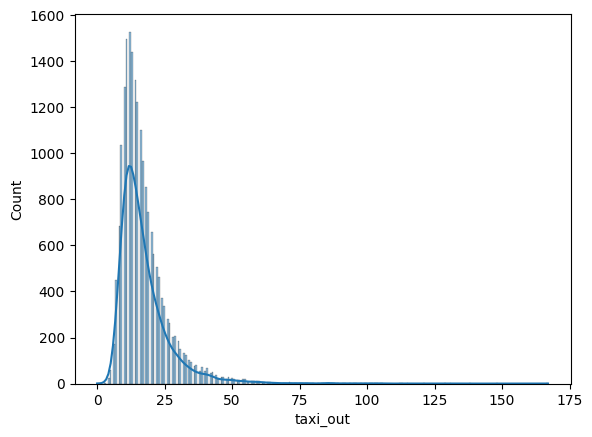

In [181]:
sns.histplot(data = df, x = "taxi_out", label = "Taxi time on outgoing", kde=True)

Text(0, 0.5, 'Arrival delay')

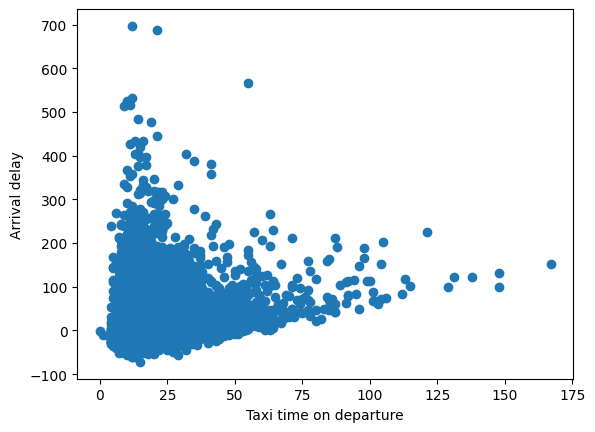

In [182]:
plt.scatter(df['taxi_out'], df['arr_delay'])
plt.xlabel("Taxi time on departure")
plt.ylabel("Arrival delay")

In [183]:
# Does time of day affect delays?
flight_delay_time = 20
delay = df[df['arr_delay']>flight_delay_time].groupby('hr_dep').count().sort_values(by=['arr_delay'], ascending=False)
total = df.groupby('hr_dep').count().sort_values(by=['arr_delay'], ascending=False)

mon_df = pd.merge(delay, total, how = "inner", on='hr_dep')
mon_df = mon_df.rename(columns={'arr_delay_x': "total_delays", 'arr_delay_y': "total_flights"})
mon_df['percent_delayed'] = mon_df['total_delays']/mon_df['total_flights']
mon_df.sort_values(by=['percent_delayed'], ascending=False)['percent_delayed']

hr_dep
1     0.250000
22    0.238289
20    0.232891
19    0.228290
18    0.224365
17    0.214450
15    0.213278
21    0.194662
14    0.180651
16    0.175472
0     0.173077
13    0.162116
12    0.146283
3     0.142857
10    0.131643
11    0.126126
23    0.120690
9     0.115188
7     0.101523
8     0.100884
6     0.065562
5     0.054167
Name: percent_delayed, dtype: float64

#### **Task 5**: What is the average percentage of delays that is already created before departure? (aka are arrival delays caused by departure delays?) Are airlines able to lower the delay during the flights?



In [188]:
int_df = flight_delay[flight_delay['arr_delay'] > 0]
int_df["arr_dep_delay_diff"] = int_df['arr_delay'] - int_df['dep_delay']
delay_diff = int_df["arr_dep_delay_diff"] 
delay_diff.describe()

/tmp/ipykernel_46478/132089407.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  int_df["arr_dep_delay_diff"] = int_df['arr_delay'] - int_df['dep_delay']


count    6986.000000
mean        2.854280
std        16.252621
min       -55.000000
25%        -8.000000
50%         2.000000
75%        11.000000
max       141.000000
Name: arr_dep_delay_diff, dtype: float64

<AxesSubplot:xlabel='arr_dep_delay_diff', ylabel='Count'>

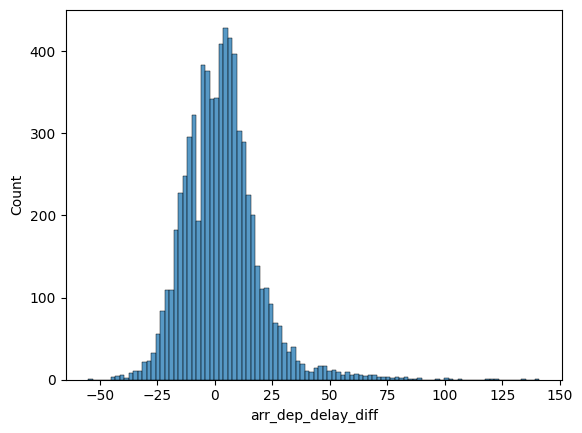

In [189]:
sns.histplot(data = delay_diff,  bins = 100)

So generally, departure delay will have a similar arrival delay, within about 15 minutes. Try a scatter plot though...

Text(0, 0.5, 'Arrival Delay')

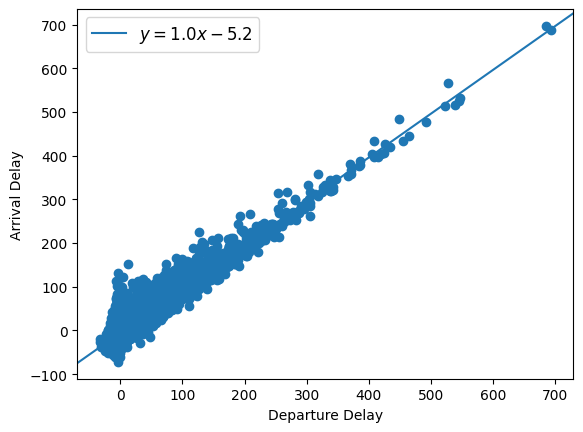

In [190]:
from sklearn.linear_model import LinearRegression


x = np.array(flight_delay['dep_delay'])
y = np.array(flight_delay['arr_delay'])
#We'll plot the regression, so let's do it first
reg = LinearRegression().fit(x.reshape(-1,1), y)
b = reg.intercept_
m = reg.coef_[0]
plt.axline(xy1=(0, b), slope=m, label=f'$y = {m:.1f}x {b:+.1f}$')
plt.scatter(flight_delay['dep_delay'], flight_delay['arr_delay'])
plt.legend(fontsize=12)
plt.xlabel("Departure Delay")
plt.ylabel("Arrival Delay")

#### **Task 6**: How many states cover 50% of US air traffic? 

#### **Task 7**: Test the hypothesis whether planes fly faster when there is the departure delay? 

- We'll use T-test for this...

In [198]:
import scipy.stats as st

flight_delay["arr_dep_delay_diff"] = flight_delay['arr_delay'] - flight_delay['dep_delay']
#I picked less than 5 minutes delay as "no delay"...I mean, it's 5 minutes.
no_delay = flight_delay[flight_delay['dep_delay'] < 5]
delay = flight_delay[flight_delay['dep_delay'] > 5]
delay_ttest = st.ttest_ind(no_delay.arr_dep_delay_diff, delay.arr_dep_delay_diff, equal_var=False )
print(delay_ttest)

Ttest_indResult(statistic=-0.4359023962813644, pvalue=0.6629192895085847)


No difference (very high p-value). Look at data, just to be sure (mean of delay_diff is the relavant variable)

In [199]:
no_delay_check = no_delay[['dep_delay', 'arr_dep_delay_diff']]
no_delay_check.describe()

,dep_delay,arr_dep_delay_diff
count,14531.000000,14531.000000
mean,-4.341133,-5.211685
std,4.001703,12.478813
min,-33.000000,-69.000000
25%,-7.000000,-12.000000
50%,-4.000000,-6.000000
75%,-2.000000,1.000000
max,4.000000,135.000000


In [200]:
delay_check = delay[['dep_delay', 'arr_dep_delay_diff']]
delay_check.describe() 

,dep_delay,arr_dep_delay_diff
count,5266.000000,5266.000000
mean,48.689518,-5.110330
std,59.618826,15.108615
min,6.000000,-61.000000
25%,13.000000,-14.000000
50%,27.000000,-7.000000
75%,60.000000,1.000000
max,693.000000,141.000000


#### **Task 8**: When (which hour) do most 'LONG', 'SHORT', 'MEDIUM' haul flights take off?

#### **Task 9**: Find the top 10 the bussiest airports. Does the biggest number of flights mean that the biggest number of passengers went through the particular airport? How much traffic do these 10 airports cover?

In [201]:
df = flight_delay[["origin", "arr_delay"]]


In [202]:
delay = df.groupby("origin")["arr_delay"].mean()
common_arpts = df.groupby("origin")["arr_delay"].count()
print(common_arpts.shape)

(347,)


In [212]:
n = 20
traffic = (common_arpts.sort_values(ascending=False).head(n).sum()/common_arpts.sort_values(ascending=False).sum())*100
print(f"The top {n} airports account for {traffic:.1f}% of the number of flights.")


#Again, only look at actual "delays", where the flight lands later than it was supposed to
df = df[df['arr_delay']>20]

delay = df.groupby("origin")["arr_delay"].mean()
common_arpts = df.groupby("origin")["arr_delay"].count()
n = 20
traffic = (common_arpts.sort_values(ascending=False).head(n).sum()/common_arpts.sort_values(ascending=False).sum())*100
print(f"The top {n} airports account for {traffic:.1f}% of the number of delayed flights.")


The top 20 airports account for 51.8% of the number of flights.
The top 20 airports account for 57.4% of the number of delayed flights.


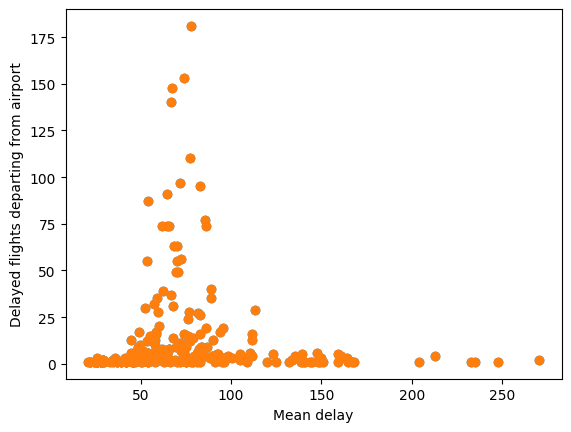

In [214]:
new_df = pd.merge(delay, common_arpts, how = "inner", on=['origin'])
new_df = new_df.rename(columns={'arr_delay_x': "mean_delay", 'arr_delay_y': "airprt_count"})

plt.scatter(new_df['mean_delay'], new_df['airprt_count'])
plt.xlabel("Mean delay")
plt.ylabel("Delayed flights departing from airport")
plt.scatter(new_df['mean_delay'], new_df['airprt_count'])

In [215]:
new_df.sort_values(by=['airprt_count'], ascending=False).head(10)

,mean_delay,airprt_count
origin,,
ORD,77.861878,181
DFW,73.973856,153
ATL,67.128378,148
DEN,67.078571,140
CLT,77.072727,110
SFO,71.628866,97
EWR,82.863158,95
LAX,64.549451,91
LAS,54.045977,87


In [217]:
# Look at individual airports, see if some are more likely to have delays
df = flight_delay[["origin", "arr_delay"]]
delay_count = df[df['arr_delay']> flight_delay_time].groupby('origin').count()
total_count = df.groupby('origin').count()

delay_df = pd.merge(delay_count, total_count, how='inner', on=['origin'])
delay_df = delay_df.rename(columns={'arr_delay_x': "total_delays", 'arr_delay_y': "total_flights"})
delay_df['percent_delayed'] = delay_df['total_delays']/delay_df['total_flights']
delay_df[delay_df['total_flights'] >300].sort_values(by=['percent_delayed'], ascending=False)

,total_delays,total_flights,percent_delayed
origin,,,
EWR,95,406,0.233990
DFW,153,714,0.214286
MCO,74,346,0.213873
SFO,97,475,0.204211
LAS,87,445,0.195506
BOS,77,399,0.192982
DEN,140,729,0.192044
ORD,181,953,0.189927
JFK,55,302,0.182119


In [218]:
delay_df['total_delays'].sum()/delay_df['total_flights'].sum() #Total percent of flights delayed

0.16163991411921072

In [208]:
## See if specific airports ar more likely to have delays
# sns.histplot(data = df, x = "dep_time", label = "Departure time", kde=True)

#### **Task 10**: Do bigger delays lead to bigger fuel comsumption per passenger? 
We need to do four things to answer this as accurate as possible:
- Find out average monthly delay per air carrier (monthly delay is sum of all delays in 1 month)
- Find out distance covered monthly by different air carriers
- Find out number of passengers that were carried by different air carriers
- Find out total fuel comsumption per air carrier.

Use this information to get the average fuel comsumption per passenger per km. Is this higher for the airlines with bigger average delays?

#### Task...11? Find flight delays based on aircrat operator

In [219]:
op_df = flight_delay[['mkt_unique_carrier', 'arr_delay']]
delay = op_df[op_df['arr_delay']>20].groupby('mkt_unique_carrier').count().sort_values(by=['arr_delay'], ascending=False)
total = op_df.groupby('mkt_unique_carrier').count().sort_values(by=['arr_delay'], ascending=False)
al_df = pd.merge(delay, total, how = "inner", on='mkt_unique_carrier')
al_df = al_df.rename(columns={'arr_delay_x': "total_delays", 'arr_delay_y': "total_flights"})
al_df['percent_delayed'] = al_df['total_delays']/al_df['total_flights']
al_df.sort_values(by=['percent_delayed'], ascending=False)

,total_delays,total_flights,percent_delayed
mkt_unique_carrier,,,
F9,83,345,0.240580
B6,172,747,0.230254
G4,48,249,0.192771
UA,687,3938,0.174454
AA,877,5119,0.171323
NK,70,451,0.155211
VX,2,13,0.153846
WN,532,3474,0.153138
AS,134,1073,0.124884


F9: Frontier Airlines; B6: JetBlue

In [220]:
# Find delays by date...

fl_perday = flight_delay.groupby('fl_date')['mkt_unique_carrier'].count()
del_perday = flight_delay[flight_delay["arr_delay"]>20].groupby('fl_date')['mkt_unique_carrier'].count()
date_df = pd.merge(del_perday, fl_perday, how = "inner", on='fl_date')
date_df = date_df.rename(columns={'mkt_unique_carrier_x': "total_delays", 'mkt_unique_carrier_y': "total_flights"})
date_df['percent_delayed'] = date_df['total_delays']/date_df['total_flights']
date_df.sort_values(by=['percent_delayed'], ascending=False).head(10)


,total_delays,total_flights,percent_delayed
fl_date,,,
2019-12-20,17,33,0.515152
2019-01-31,9,18,0.500000
2019-12-09,11,22,0.500000
2018-11-26,13,30,0.433333
2018-12-27,13,30,0.433333
2019-05-11,11,26,0.423077
2018-06-19,11,26,0.423077
2019-07-18,13,31,0.419355
2018-08-13,10,24,0.416667


Does distance of flight matter?

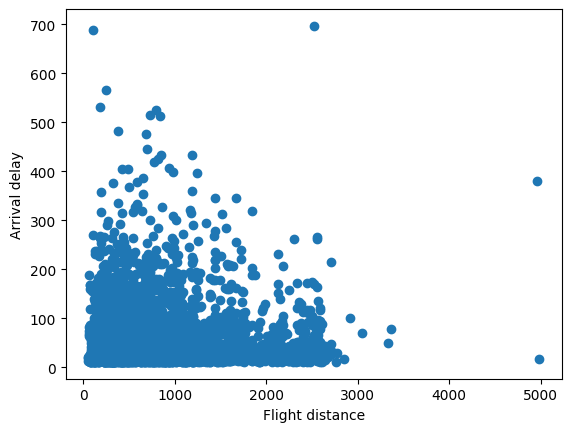

In [211]:

plt.scatter(flight_delay[flight_delay['arr_delay']>10]['distance'], flight_delay[flight_delay['arr_delay']>10]['arr_delay'])
plt.xlabel('Flight distance')
plt.ylabel('Arrival delay')
plt.show()

...no